# Model 2: Anatomically accurate model of Amygdala

1. target behavioral data
    - conditioned fear response
    - extinction-induced reduction of fear response
    - renewal of fear response when the CS is presented in the original context
2. target activity data
    - LA pyramidal neurons (PN) become CS-responsive after conditioning
    - LA pyramidal neurons (PN) maintain CS-responsiveness after extinction
    - LA inhibitory neurons (PV and SOM) respond to the US, releasing inhibition of LA pyramidal cells
    - BLA fear neurons (excitatory) become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - BLA extinction neurons (excitatory) become CS-responsive after extinction
    - BLA persistent neurons (excitatory) become CS-responsive after conditioning and maintain their activity after extinction
    - CeL "on" neurons (inhibitory) become more responsive to CS following conditioning
    - CeL "off" neurons (inhibitory) become less responsive to CS following conditioning


In [29]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from uniform_encoders import *

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [4]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = ScatteredHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.stop_learning = 0  # control signal to turn learning off
        self.applied_current = 0  # for experiments with external perturbation
        self.pause = False
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied and not self.pause else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1.5 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0
    def get_stop_learning(self, t):
        return self.stop_learning
    def get_applied_current(self, t):
        return self.applied_current

In [3]:
dt = 0.001
nCond = 5
nExt = 10
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 5
nCS = 1
nCTX = 2
intercept_CS = 0
intercept_CTX = 0
intercept_LA_pyr = -0.2
lr = 5e-5

rng = np.random.RandomState(seed=seed)
sampler = ScatteredHypersphere(surface=True)

inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
dInh = -3e0*np.ones((nNeurons, 1))

## Version 1
 - LA pyramidal and interneurons; functionally similar to model 1.1. LA neurons are divided into those response to US and those responsive to CS
 - PES learning updates connections weights from external_CS to LA_pyr, such that LA_pyr's CS response increases when the US is present alongside the CS
 - LA_inh receives CS and US information from external_CS and external_US via fixed connections, then gates learning in LA_pyr via inhibition

In [4]:
net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.03
net.config[nengo.Probe].synapse = 0.03

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_pyr[1])
    # internal connections
    nengo.Connection(LA_pyr[1], LA_inh[1])
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr))
    # error connections
    nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
    nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    # prevent learning during testing
    nengo.Connection(stop_learning, error_LA.neurons, transform=dInh)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pError_LA = nengo.Probe(error_LA)

In [5]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
#     print("pause")
#     inputs.pause = True
#     inputs.CTX = np.zeros((dim_CTX))
#     inputs.US = 0
#     sim.run(4)
#     inputs.pause = False
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


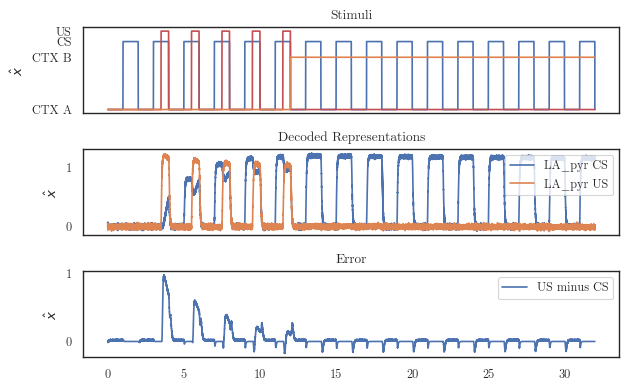

In [6]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((6.38,4)), gridspec_kw={'height_ratios': [2,2,2]})
axes[0].plot(sim.trange(), 1.3*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[0].plot(sim.trange(), 1.5*sim.data[pUS], label="US", c='r')
axes[0].plot(sim.trange(), ctx_signal, label="CTX")
axes[0].set(yticks=((0,1,1.3,1.5)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="LA_pyr CS")
axes[1].plot(sim.trange(), sim.data[pLA_pyr][:,1], label="LA_pyr US")
axes[1].legend(loc='upper right')
axes[1].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel=r"$\hat{x}$", title="Decoded Representations")
axes[2].plot(sim.trange(), sim.data[pError_LA], label="US minus CS")
axes[2].legend()
axes[2].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()
fig.savefig("model2_LA_dynamics.svg")
fig.savefig("model2_LA_dynamics.png", dpi=600)

34.0% of LA neurons become more CS responsive, 39.5% become less CS responsive


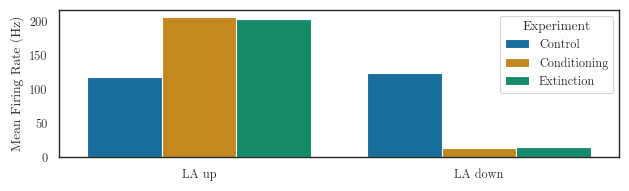

In [8]:
T1a = int(1/dt)
T1b = int(2/dt)
T2a = int((2+2*nCond-1)/dt)
T2b = int((2+2*nCond-0.5)/dt)
T3a = int((2+2*nCond+2*nExt-1)/dt)
T3b = int((2+2*nCond+2*nExt-0.5)/dt)
data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
            
aControl_LA_pyr = sim.data[pLA_pyr_spikes][T1a: T1b]
aConditioning_LA_pyr = sim.data[pLA_pyr_spikes][T2a: T2b]
aExtinction_LA_pyr = sim.data[pLA_pyr_spikes][T3a: T3b]
LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]

data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38,2)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None, ylabel="Mean Firing Rate (Hz)")
plt.tight_layout()
fig.savefig("model2_LA_responses.svg")
fig.savefig("model2_LA_responses.png", dpi=600)

percent_up = len(LA_pyr_up)/(2*nNeurons)*100
percent_down = len(LA_pyr_down)/(2*nNeurons)*100
print(f"{percent_up}% of LA neurons become more CS responsive, {percent_down}% become less CS responsive")

## Version 2
 - adds CeL and CeM. These populations convey LA_pyr output (learned CS responses) to the amygdala's output, causing fear response
 - PES learning updates connections weights from LA_pyr to CeL, such that CeL's CS response increases when the US is present alongside the CS
 - A constant bias is sent to CeM and to one dimension of CeL. This causes CeM, and some neurons in CeL, to fire without external input. These spontaneously active CeL cells inhibit CeM, such that, with no external input, CeM is quiet, and no fear response occurs
 - When CeL becomes conditioned to respond to CS via learned projections from LA, CS-responsive CeL neurons compete with spontaneously active CeL neurons to activate CeM, causing fear response. We realize this competition via a functional connection from CeL (CS-response minus bias); biologically, this likely happens through lateral inhibition in CeL and disinhibition of CeM.

In [9]:
lr1 = 5e-5
lr2 = 2e-4

net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.03
net.config[nengo.Probe].synapse = 0.03

intercepts_pos = nengo.dists.Uniform(0,1)
encoders_pos = nengo.dists.Choice([[1]])

with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    bias = nengo.Node(lambda t: 1.0)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
    CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
    CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    error_CeL = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_pyr[1])
    nengo.Connection(bias, CeL_off)
    nengo.Connection(bias, CeM)
    # internal connections
    nengo.Connection(LA_pyr[1], LA_inh[1])
    nengo.Connection(CeL_on, CeL_off, transform=-1)
    nengo.Connection(CeL_off, CeM, transform=-1)
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
    transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
    # error connections
    nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
    nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
    nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
    nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
    pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
    pCeM_spikes = nengo.Probe(CeM.neurons)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pCeL_on = nengo.Probe(CeL_on)
    pCeL_off = nengo.Probe(CeL_off)
    pCeM = nengo.Probe(CeM)
    pError_LA = nengo.Probe(error_LA)
    pError_CeL = nengo.Probe(error_CeL)

In [10]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
#     print("pause")
#     inputs.pause = True
#     inputs.CTX = np.zeros((dim_CTX))
#     inputs.US = 0
#     sim.run(4)
#     inputs.pause = False
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


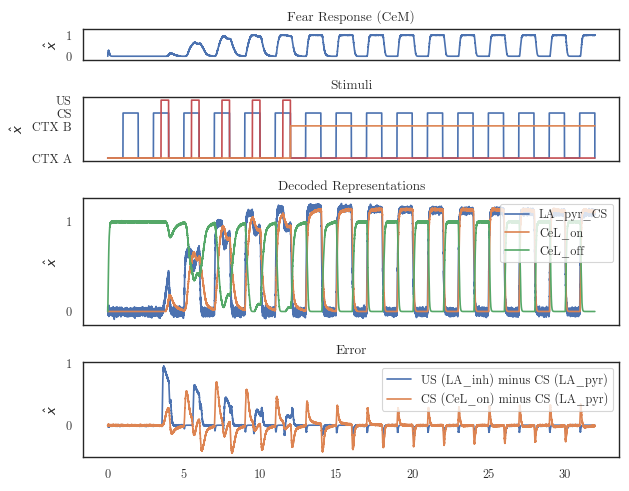

In [13]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((6.38,5)), gridspec_kw={'height_ratios': [1,2,4,3]})
axes[0].plot(sim.trange(), sim.data[pCeM])
axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response (CeM)", yticks=((0,1)), ylim=((-0.2, 1.3)))
axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.8*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].set(yticks=((0,1,1.4,1.8)), yticklabels=(("CTX A","CTX B","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="LA_pyr_CS")
axes[2].plot(sim.trange(), sim.data[pCeL_on], label="CeL_on")
axes[2].plot(sim.trange(), sim.data[pCeL_off], label="CeL_off")
axes[2].legend(loc='upper right')
axes[2].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel=r"$\hat{x}$", title="Decoded Representations")
axes[3].plot(sim.trange(), sim.data[pError_LA], label="US (LA_inh) minus CS (LA_pyr)")
axes[3].plot(sim.trange(), sim.data[pError_CeL], label="CS (CeL_on) minus CS (LA_pyr)")
axes[3].legend(loc='upper right')
axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
plt.tight_layout()
fig.savefig("model2_CeL_dynamics.svg")
fig.savefig("model2_CeL_dynamics.png", dpi=600)

## Version 3
 - return to version 1, then add a BLA, which includes BLA_pyramidal and BLA_interneurons. Functionally similar to model1.3
 - BLA_pyr and BLA_inh receive [CS, US] information from LA_pyr
 - BLA_pyr receives an external connection conveying CTX information. Use PES learning on this connection such that two trends occur (mediated by separate error populations):
    - when CTX is present alongside US, learn a fear association between the two (error = BLA_US - BLA_CTX). This error should be inhibited unless the US is present
    - when CTX is present alongside BLA_CS response, but no US is present, learn a safety association between CTX and CS (error = BLA_CS - BLA_CTX) (technically CS + CTX, because BLA_CTX representation becomes negative)
 - BLA_inh gates the BLA_error populations appropriately, given CS and US information

In [39]:
dt = 0.001
nCond = 5
nExt = 10
seed = 0
nNeurons = 100
dim_CS = 3
dim_CTX = 5
nCS = 1
nCTX = 2
intercept_CS = 0
intercept_CTX = 0
intercept_LA_pyr = -0.2
intercept_BLA_pyr = 0.0
lr1 = 3e-5
lr2 = 1e-4
lr3 = 1e-5

rng = np.random.RandomState(seed=seed)
sampler = ScatteredHypersphere(surface=True)

inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
intercepts_pos = nengo.dists.Uniform(0,1)
encoders_pos = nengo.dists.Choice([[1]])
encoders_BLA_pyr = sampler.sample(3*nNeurons, 3, rng=rng)
intercepts_BLA_pyr = nengo.dists.Uniform(intercept_BLA_pyr, intercept_BLA_pyr)

dInh = -3e0*np.ones((nNeurons, 1))

net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.03
net.config[nengo.Probe].synapse = 0.03
    
with net:
    # inputs and outputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    bias = nengo.Node(lambda t: 0.5)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
    # amygdala ensembles
    LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
    LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
    CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
    CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
    BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    # error ensembles
    error_LA = nengo.Ensemble(nNeurons, 1)
    error_CeL = nengo.Ensemble(nNeurons, 1)
    error_BLA_safe = nengo.Ensemble(nNeurons, 1)
    error_BLA_fear = nengo.Ensemble(nNeurons, 1)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
    nengo.Connection(external_US, LA_pyr[1])
    nengo.Connection(bias, CeL_off, transform=1)
    nengo.Connection(bias, CeM)
    nengo.Connection(CTX, external_CTX, synapse=None)
    # internal connections
    nengo.Connection(LA_pyr[1], LA_inh[1])
    nengo.Connection(CeL_on, CeL_off, transform=-1)
    nengo.Connection(CeL_off, CeM, transform=-1)
    nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
    nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
    nengo.Connection(BLA_pyr[0], CeM, transform=0.25)  # CS response added to total fear response
    nengo.Connection(BLA_pyr[2], CeM, transform=0.75)  # CTX response added to total fear response
    # learned connections
    conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
    transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
    extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(lr3))
    # error connections
    nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
    nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
    nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
    nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
#     nengo.Connection(BLA_pyr, error_BLA_safe, function=lambda x: x[0]+x[2])  # CS response + (-) CTX response
#     nengo.Connection(BLA_pyr, error_BLA_fear, function=lambda x: x[1]-x[2])   # US response - CTX response
    nengo.Connection(BLA_pyr[2], error_BLA_safe)  # CTX response
    nengo.Connection(BLA_pyr[2], error_BLA_fear, transform=-1)  # -CTX response
    nengo.Connection(BLA_inh[0], error_BLA_safe)  # CS response
    nengo.Connection(BLA_inh[1], error_BLA_fear)  # US
    # error gating
    nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
#     nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0]+x[1], transform=dInh)  # inhibit by default; release if CS
    nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
    nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=0.3)  # inhibit by default; release if CS
    nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=0.5*dInh)  # slow learning unless US
    # error updating
    nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
    nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
    nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
    nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-2)

    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
    pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
    pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
    pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
    pCeM_spikes = nengo.Probe(CeM.neurons)
    pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
    pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
    pBLA_pyr = nengo.Probe(BLA_pyr)
    pBLA_inh = nengo.Probe(BLA_inh)
    pLA_pyr = nengo.Probe(LA_pyr)
    pLA_inh = nengo.Probe(LA_inh)
    pCeL_on = nengo.Probe(CeL_on)
    pCeL_off = nengo.Probe(CeL_off)
    pCeM = nengo.Probe(CeM)
    pError_LA = nengo.Probe(error_LA)
    pError_CeL = nengo.Probe(error_CeL)
    pBLA_pyr = nengo.Probe(BLA_pyr)
    pBLA_inh = nengo.Probe(BLA_inh)
    pBLA_inh_long = nengo.Probe(BLA_inh[1], synapse=0.3)
    pError_BLA_safe = nengo.Probe(error_BLA_safe)
    pError_BLA_fear = nengo.Probe(error_BLA_fear)    

In [40]:
sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("control")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
#     print("pause")
#     inputs.pause = True
#     inputs.CTX = np.zeros((dim_CTX))
#     inputs.US = 0
#     sim.run(4)
#     inputs.pause = False
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)

control
conditioning
extinction


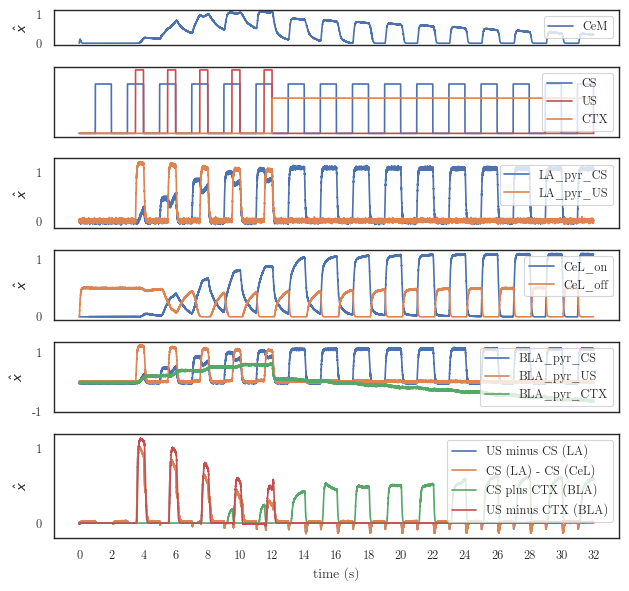

In [55]:
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1

fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=((6.38,6)), gridspec_kw={'height_ratios': [1,2,2,2,2,3]})
axes[0].plot(sim.trange(), sim.data[pCeM], label="CeM")
axes[0].set(ylabel=r"$\hat{x}$", yticks=((0,1)))  #  title="Fear Response",
axes[0].legend(loc='upper right')
axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS")
axes[1].plot(sim.trange(), 1.8*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), ctx_signal, label="CTX")
axes[1].legend(loc='upper right')
axes[1].set(ylabel=None,  yticks=(()))  # , title="Stimuli")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,0], label="LA_pyr_CS")
axes[2].plot(sim.trange(), sim.data[pLA_pyr][:,1], label="LA_pyr_US")
axes[2].legend(loc='upper right')
axes[2].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel=r"$\hat{x}$")  # , title="LA Decoded Values")
axes[3].plot(sim.trange(), sim.data[pCeL_on], label="CeL_on")
axes[3].plot(sim.trange(), sim.data[pCeL_off], label="CeL_off")
axes[3].legend(loc='upper right')
axes[3].set(yticks=((0, 1)), yticklabels=((0,1)), ylabel=r"$\hat{x}$")  # , title="CeL Decoded Values")
axes[4].plot(sim.trange(), sim.data[pBLA_pyr][:,0], label="BLA_pyr_CS")
axes[4].plot(sim.trange(), sim.data[pBLA_pyr][:,1], label="BLA_pyr_US")
axes[4].plot(sim.trange(), sim.data[pBLA_pyr][:,2], label="BLA_pyr_CTX")
axes[4].legend(loc='upper right')
axes[4].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$")  # , title="BLA Decoded Values")
axes[5].plot(sim.trange(), sim.data[pError_LA], label="US minus CS (LA)")
axes[5].plot(sim.trange(), sim.data[pError_LA], label="CS (LA) - CS (CeL)")
axes[5].plot(sim.trange(), sim.data[pError_BLA_safe], label="CS plus CTX (BLA)")
axes[5].plot(sim.trange(), sim.data[pError_BLA_fear], label="US minus CTX (BLA)")
axes[5].legend(loc='upper right')
axes[5].set(xlabel='time (s)', xticks=np.arange(0, 34, 2), ylabel=r"$\hat{x}$", yticks=((0,1)))  #  title="Errors",
plt.tight_layout()
fig.savefig("model2_BLA_dynamics.svg")
fig.savefig("model2_BLA_dynamics.png", dpi=600)

percent fear: 6.75
percent extinction: 10.50
percent persistent: 29.50


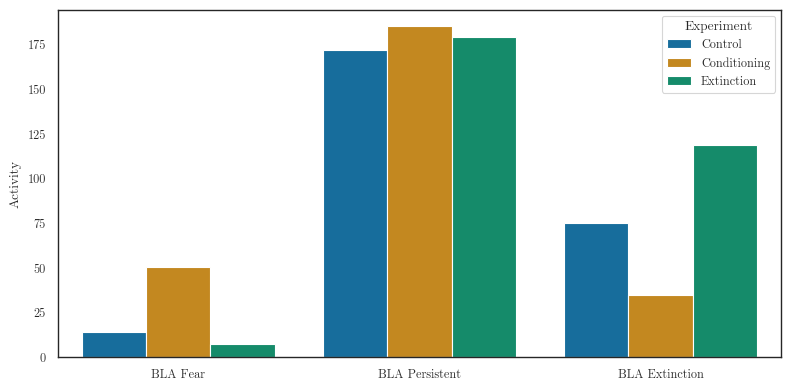

In [56]:
T1a = int(1/dt)
T1b = int(2/dt)
T4a = int((2+2*nCond-1)/dt)
T4b = int((2+2*nCond-0.5)/dt)
T5a = int((2+2*nCond+2*nExt-1)/dt)
T5b = int((2+2*nCond+2*nExt-0.5)/dt)
data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])

aControl_BLA = sim.data[pBLA_pyr_spikes][T1a: T1b]
aConditioning_BLA = sim.data[pBLA_pyr_spikes][T4a: T4b]
aExtinction_BLA = sim.data[pBLA_pyr_spikes][T5a: T5b]    
fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

percent_fear = len(fear_neurons)/(4*nNeurons)*100
percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
percent_persistent = len(persistent_neurons)/(4*nNeurons)*100

print(f"percent fear: {percent_fear:.2f}")
print(f"percent extinction: {percent_extinction:.2f}")
print(f"percent persistent: {percent_persistent:.2f}")

data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((8,4)))
sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
ax.set(xlabel=None)
plt.tight_layout()

# Model 2 Experiments

In [12]:
def build_network(
        dt = 0.001,
        nCond = 5,
        nExt = 10,
        seed = 0,
        nNeurons = 100,
        dim_CS = 3,
        dim_CTX = 5,
        nCS = 1,
        nCTX = 3,
        intercept_CS = 0,
        intercept_CTX = 0,
        intercept_LA_pyr = -0.2,
        lr1 = 3e-5,
        lr2 = 1e-4,
        lr3 = 1e-5,
        T_BLA_CS=0.25,
        T_BLA_CTX=0.75,
    ):

    rng = np.random.RandomState(seed=seed)
    sampler = ScatteredHypersphere(surface=True)

    inputs = Inputs(dim_CS=dim_CS, dim_CTX=dim_CTX, nCS=nCS, nCTX=nCTX, seed=seed)

    encoders_LA_pyr = sampler.sample(2*nNeurons, 2, rng=rng)
    intercepts_LA_pyr = nengo.dists.Uniform(intercept_LA_pyr, intercept_LA_pyr)
    encoders_CS = sampler.sample(dim_CS*nNeurons, dim_CS, rng=rng)
    encoders_CTX = sampler.sample(dim_CTX*nNeurons, dim_CTX, rng=rng)
    intercepts_CS = nengo.dists.Uniform(intercept_CS, intercept_CS)
    intercepts_CTX = nengo.dists.Uniform(intercept_CTX, intercept_CTX)
    intercepts_pos = nengo.dists.Uniform(0,1)
    encoders_pos = nengo.dists.Choice([[1]])

    dInh = -3e0*np.ones((nNeurons, 1))

    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03

    with net:
        # inputs and outputs
        CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
        US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
        CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
        bias = nengo.Node(lambda t: 0.5)
        stop_learning = nengo.Node(lambda t, x: inputs.get_stop_learning(t), size_in=2)
        applied_current = nengo.Node(lambda t, x: inputs.get_applied_current(t), size_in=2)
        # external ensembles
        external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS, intercepts=intercepts_CS, encoders=encoders_CS)
        external_US = nengo.Ensemble(nNeurons, 1)
        external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_CTX, encoders=encoders_CTX)
        # amygdala ensembles
        LA_pyr = nengo.Ensemble(2*nNeurons, 2, radius=2, encoders=encoders_LA_pyr, intercepts=intercepts_LA_pyr)  # [CS, US]
        LA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        CeL_on = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [CS]
        CeL_off = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [bias-CS]
        CeM = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
        BLA_pyr = nengo.Ensemble(3*nNeurons, 3, radius=3)  # [CS, US, CTX]
        BLA_inh = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
        # error ensembles
        error_LA = nengo.Ensemble(nNeurons, 1)
        error_CeL = nengo.Ensemble(nNeurons, 1)
        error_BLA_safe = nengo.Ensemble(nNeurons, 1)
        error_BLA_fear = nengo.Ensemble(nNeurons, 1)
        # external connections
        nengo.Connection(CS, external_CS, synapse=None)
        nengo.Connection(US, external_US, synapse=None)
        nengo.Connection(external_CS, LA_inh[0], function=lambda x: np.sum(np.square(x)))  # any CS present
        nengo.Connection(external_US, LA_pyr[1])
        nengo.Connection(bias, CeL_off, transform=1)
        nengo.Connection(bias, CeM)
        nengo.Connection(CTX, external_CTX, synapse=None)
        # internal connections
        nengo.Connection(LA_pyr[1], LA_inh[1])
        nengo.Connection(CeL_on, CeL_off, transform=-1)
        nengo.Connection(CeL_off, CeM, transform=-1)
        nengo.Connection(LA_pyr, BLA_pyr[:2])  # communicate [CS, US]
        nengo.Connection(BLA_pyr[:2], BLA_inh)  # communicate [CS,US]
        nengo.Connection(BLA_pyr[0], CeM, transform=T_BLA_CS)  # CS response added to total fear response
        nengo.Connection(BLA_pyr[2], CeM, transform=T_BLA_CTX)  # CTX response added to total fear response
        # learned connections
        conditioning = nengo.Connection(external_CS, LA_pyr[0], function=lambda x: 0, learning_rule_type=nengo.PES(lr1))
        transmission = nengo.Connection(LA_pyr[0], CeL_on, function=lambda x: 0, learning_rule_type=nengo.PES(lr2))
        extinction = nengo.Connection(external_CTX, BLA_pyr[2], function=lambda x: 0, learning_rule_type=nengo.PES(lr3))
        # error connections
        nengo.Connection(LA_pyr[0], error_LA, transform=-1)  # -CS response
        nengo.Connection(LA_inh[1], error_LA, transform=+1)  # US
        nengo.Connection(LA_pyr[0], error_CeL, transform=+1)  # LA_pyr CS response
        nengo.Connection(CeL_on, error_CeL, transform=-1)  # -CeL_on CS response
        nengo.Connection(BLA_pyr[2], error_BLA_safe)  # CTX response
        nengo.Connection(BLA_pyr[2], error_BLA_fear, transform=-1)  # -CTX response
        nengo.Connection(BLA_inh[0], error_BLA_safe)  # CS response
        nengo.Connection(BLA_inh[1], error_BLA_fear)  # US
        # error gating
        nengo.Connection(LA_inh, error_LA.neurons, function=lambda x: x[0]-x[1], transform=dInh)  # inhibit if only CS present
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: 1-x[0], transform=dInh)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_safe.neurons, function=lambda x: x[1], transform=10*dInh, synapse=0.3)  # inhibit by default; release if CS
        nengo.Connection(BLA_inh, error_BLA_fear.neurons, function=lambda x: 1-x[1], transform=0.5*dInh)  # slow learning unless US
        # error updating
        nengo.Connection(error_LA, conditioning.learning_rule, transform=-1)
        nengo.Connection(error_CeL, transmission.learning_rule, transform=-1)
        nengo.Connection(error_BLA_safe, extinction.learning_rule, transform=1)
        nengo.Connection(error_BLA_fear, extinction.learning_rule, transform=-2)

        # probes
        net.pCS = nengo.Probe(CS, synapse=None)
        net.pUS = nengo.Probe(US, synapse=None)
        net.pCTX = nengo.Probe(CTX, synapse=None)
        net.pLA_pyr_spikes = nengo.Probe(LA_pyr.neurons)
        net.pLA_inh_spikes = nengo.Probe(LA_inh.neurons)
        net.pCeL_on_spikes = nengo.Probe(CeL_on.neurons)
        net.pCeL_off_spikes = nengo.Probe(CeL_off.neurons)
        net.pCeM_spikes = nengo.Probe(CeM.neurons)
        net.pBLA_pyr_spikes = nengo.Probe(BLA_pyr.neurons)
        net.pBLA_inh_spikes = nengo.Probe(BLA_inh.neurons)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pLA_pyr = nengo.Probe(LA_pyr)
        net.pLA_inh = nengo.Probe(LA_inh)
        net.pCeL_on = nengo.Probe(CeL_on)
        net.pCeL_off = nengo.Probe(CeL_off)
        net.pCeM = nengo.Probe(CeM)
        net.pError_LA = nengo.Probe(error_LA)
        net.pError_CeL = nengo.Probe(error_CeL)
        net.pBLA_pyr = nengo.Probe(BLA_pyr)
        net.pBLA_inh = nengo.Probe(BLA_inh)
        net.pError_BLA_safe = nengo.Probe(error_BLA_safe)
        net.pError_BLA_fear = nengo.Probe(error_BLA_fear)
        
        # save pointers
        net.inputs = inputs
        net.applied_current = applied_current
        net.LA_pyr = LA_pyr
        net.LA_inh = LA_inh
        net.CeL_on = CeL_on
        net.CeL_off = CeL_off
        net.CeM = CeM
        net.BLA_pyr = BLA_pyr
        net.BLA_inh = BLA_inh
        net.error_LA = error_LA
        net.error_CeL = error_CeL
        net.error_BLA_safe = error_BLA_safe
        net.error_BLA_fear = error_BLA_fear
        
    return net

### Baseline experiment: behavioral and activity data for normal conditioning, extinction, and testing

In [37]:
def run_single(
        seeds=1,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCS=1,
        nCTX=3,
        load=False,
        plot=False,
    ):

    if load:
        data_fear = pd.read_pickle("model2_fear.pkl")
        data_activity = pd.read_pickle("model2_activity.pkl")        
        data_response = pd.read_pickle("model2_response.pkl")        
    else:
        data_fear = pd.DataFrame(columns=["seed", "Fear Response", "Experiment"])
        data_activity = pd.DataFrame(columns=["seed", "Type", "Activity", "Experiment"])
        data_response = pd.DataFrame(columns=["seed", "Type", "Percent"])
        rng = np.random.RandomState(seeds)

        for s in range(seeds):
            print(f"seed={s}")
            seed = s
            lr1 = rng.uniform(2e-5, 4e-5)
            lr2 = rng.uniform(8e-5, 2e-4)
            lr3 = rng.uniform(8e-6, 2e-5)
            T_BLA_CS = rng.uniform(0.2, 0.4)
            T_BLA_CTX = rng.uniform(0.5, 1.0)
            net = build_network(seed=s, lr1=lr1, lr2=lr2, lr3=lr3, T_BLA_CS=T_BLA_CS, T_BLA_CTX=T_BLA_CTX,
                dt=dt, nNeurons=nNeurons, nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
            sim = nengo.Simulator(net, dt=dt, progress_bar=False)
            with sim:
                net.inputs.stop_learning = 0
                print("control")
                net.inputs.CTX = net.inputs.CTXs[0]
                sim.run(2)
                T1a = int(1/dt)
                T1b = int(2/dt)
                print("conditioning")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 1
                for p in range(nCond):
                    sim.run(2)
                T2a = int((2+2*nCond-1)/dt)
                T2b = int((2+2*nCond-0.5)/dt)
                print("extinction")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                for p in range(nExt):
                    sim.run(2)
                T3a = int((2+2*nCond+2*nExt-1)/dt)
                T3b = int((2+2*nCond+2*nExt-0.5)/dt)
        #         print("turn learning off for testing")
                net.inputs.stop_learning = 1
                print("test CTX A")
                net.inputs.CTX = net.inputs.CTXs[0]
                net.inputs.US = 0
                sim.run(2)
                T4a = int((2+2*nCond+2*nExt+1)/dt)
                T4b = int((2+2*nCond+2*nExt+1.5)/dt)
                print("test CTX B")
                net.inputs.CTX = net.inputs.CTXs[1]
                net.inputs.US = 0
                sim.run(2)
                T5a = int((2+2*nCond+2*nExt+2+1)/dt)
                T5b = int((2+2*nCond+2*nExt+2+1.5)/dt)  
                print("test CTX C")
                net.inputs.CTX = net.inputs.CTXs[2]
                net.inputs.US = 0
                sim.run(2)
                T6a = int((2+2*nCond+2*nExt+2+2+1)/dt)
                T6b = int((2+2*nCond+2*nExt+2+2+1.5)/dt)  

            if plot:
                ctxA_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[0])[0]
                ctxB_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[1])[0]
                ctxC_idx = np.where(sim.data[net.pCTX]==net.inputs.CTXs[2])[0]
                ctx_signal = np.zeros((sim.trange().shape[0]))
                ctx_signal2 = np.zeros((sim.trange().shape[0]))
                ctx_signal[ctxB_idx] = 1
                ctx_signal2[ctxC_idx] = 0.5
                fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [2,2,4,4]})
                axes[0].plot(sim.trange(), sim.data[net.pCeM])
                axes[0].set(ylabel=r"$\hat{x}$", title="Fear Response", yticks=((0,1)))
                axes[1].plot(sim.trange(), 1.4*np.linalg.norm(sim.data[net.pCS], ord=2, axis=1), label="CS present")
                axes[1].plot(sim.trange(), 1.8*sim.data[net.pUS], label="US", c='r')
                axes[1].plot(sim.trange(), ctx_signal)
                axes[1].plot(sim.trange(), ctx_signal2)
                axes[1].set(yticks=((0,0.5,1,1.4,1.8)), yticklabels=(("CTX+","CTXn","CTX-","CS","US")), ylabel=r"$\hat{x}$", title="Stimuli")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,0], label="BLA_pyr_CS")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,1], label="BLA_pyr_US")
                axes[2].plot(sim.trange(), sim.data[net.pBLA_pyr][:,2], label="BLA_pyr_CTX")
                axes[2].legend()
                axes[2].set(yticks=((-1, 1)), yticklabels=((-1,1)), ylabel=r"$\hat{x}$", title="Training")
                axes[3].plot(sim.trange(), sim.data[net.pError_LA], label="CS minus US")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_safe], label="CS minus CTX")
                axes[3].plot(sim.trange(), sim.data[net.pError_BLA_fear], label="US minus CTX")
                axes[3].legend()
                axes[3].set(ylabel=r"$\hat{x}$", title="Error", yticks=((0,1)))
                plt.tight_layout()

            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]),
                "Experiment": "Control"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T4a: T4b]),
                "Experiment": "CS+ and CTX+"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]),
                "Experiment": "CS+ and CTX-"},
                ignore_index=True)
            data_fear = data_fear.append({
                "Fear Response": np.mean(sim.data[net.pCeM][T6a: T6b]),
                "Experiment": "CS+ and CTX new"},
                ignore_index=True)

            aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
            aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T4a: T4b]
            aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
            aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
            aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T4a: T4b]
            aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
            aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
            aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T4a: T4b]
            aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
            aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
            aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T4a: T4b]
            aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]    

            LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
            LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
            fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
            fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
            fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
            extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
            persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Persist", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinct", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aControl_CeL_on), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aConditioning_CeL_on), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aExtinction_CeL_on), "Experiment": "Extinction"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aControl_CeL_off), "Experiment": "Control"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aConditioning_CeL_off), "Experiment": "Conditioning"}, ignore_index=True)
            data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aExtinction_CeL_off), "Experiment": "Extinction"}, ignore_index=True)

            percent_up = len(LA_pyr_up)/(2*nNeurons)*100
            percent_down = len(LA_pyr_down)/(2*nNeurons)*100
            percent_fear = len(fear_neurons)/(4*nNeurons)*100
            percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
            percent_persistent = len(persistent_neurons)/(4*nNeurons)*100
            data_response = data_response.append({"seed": seed, "Type": "LA up", "Percent": percent_up}, ignore_index=True)
            data_response = data_response.append({"seed": seed, "Type": "LA down", "Percent": percent_down}, ignore_index=True)
            data_response = data_response.append({"seed": seed, "Type": "BLA Fear", "Percent": percent_fear}, ignore_index=True)
            data_response = data_response.append({"seed": seed, "Type": "BLA Extinct", "Percent": percent_extinction}, ignore_index=True)
            data_response = data_response.append({"seed": seed, "Type": "BLA Persist", "Percent": percent_persistent}, ignore_index=True)

        data_fear.to_pickle("model2_fear.pkl")
        data_activity.to_pickle("model2_activity.pkl")
        data_response.to_pickle("model2_response.pkl")
            
    fig, ax = plt.subplots(figsize=((6.38,2)))
    sns.barplot(data=data_fear, x='Experiment', y="Fear Response", palette=palette)
    ax.set(xlabel=None, yticks=((0,1)), title="Fear Expression")
    plt.tight_layout()
    fig.savefig("model2_fear_expression.svg")
    fig.savefig("model2_fear_expression.png", dpi=600)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((6.38,3)))
    sns.barplot(data=data_activity, x='Type', y="Activity", hue="Experiment", palette=palette, ax=ax)
    ax.set(xlabel=None, ylabel="Mean Firing Rate (Hz)", title="Neural Responses")
    plt.legend(loc='upper right')
    plt.tight_layout()
    fig.savefig("model2_neuron_responses.svg")
    fig.savefig("model2_neuron_responses.png", dpi=600)
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=((6.38,2)), sharey=True)
    sns.histplot(data=data_response.query("Type=='LA up'")['Percent'], stat="percent", bins=10, ax=axes[0])
    sns.histplot(data=data_response.query("Type=='LA down'")['Percent'], stat="percent", bins=10, ax=axes[1])
    sns.histplot(data=data_response.query("Type=='BLA Fear'")['Percent'], stat="percent", bins=10, ax=axes[2])
    sns.histplot(data=data_response.query("Type=='BLA Persist'")['Percent'], stat="percent", bins=10, ax=axes[3])
    sns.histplot(data=data_response.query("Type=='BLA Extinct'")['Percent'], stat="percent", bins=10, ax=axes[4])
    axes[0].set(title="LA Up", ylabel="Frequency of observation\nacross networks")
    axes[1].set(title="LA Down")
    axes[2].set(title="BLA Fear")
    axes[3].set(title="BLA Persist")
    axes[4].set(title="BLA Extinct")
    plt.tight_layout()
    fig.savefig("model2_neuron_types.svg")
    fig.savefig("model2_neuron_types.png", dpi=600)


seed=0
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=1
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=2
control
conditioning
extinction
test CTX A
test CTX B
test CTX C


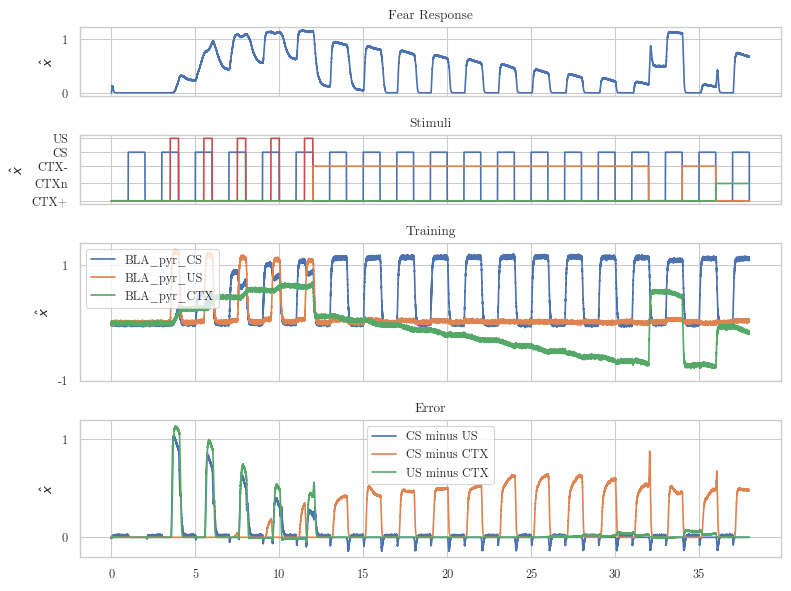

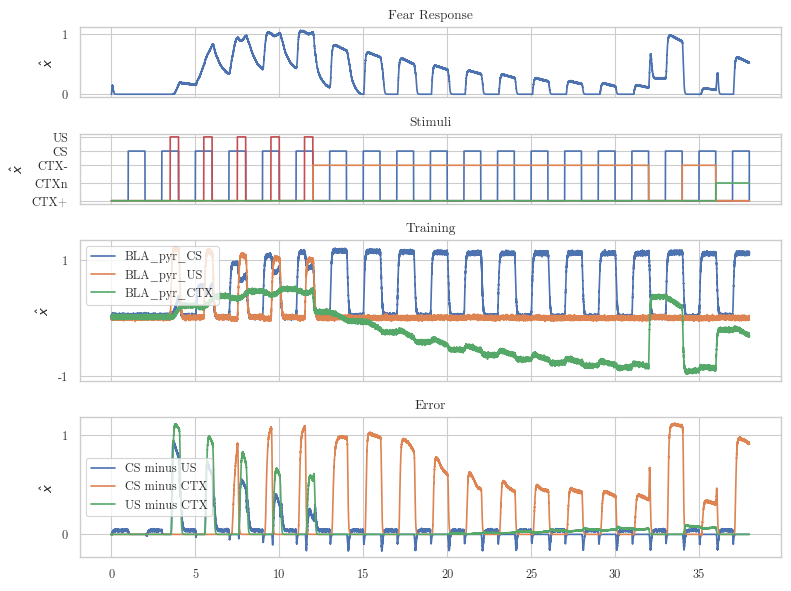

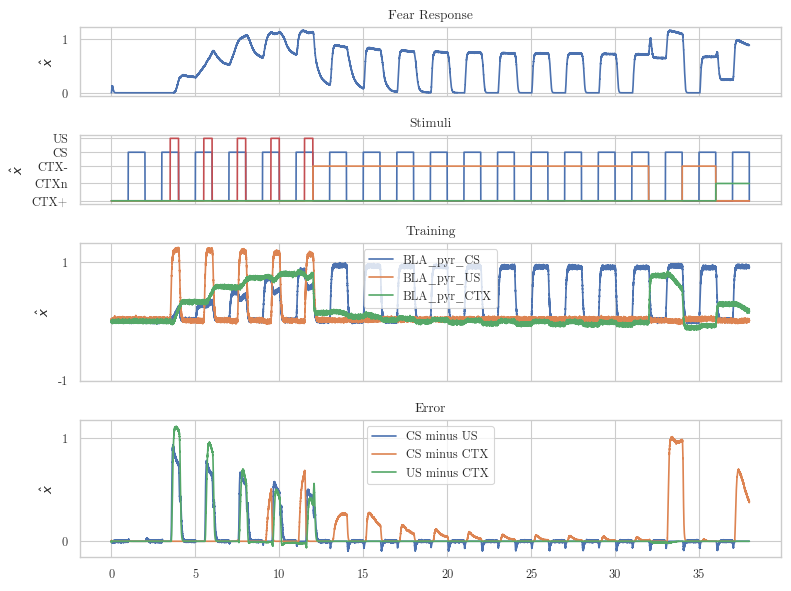

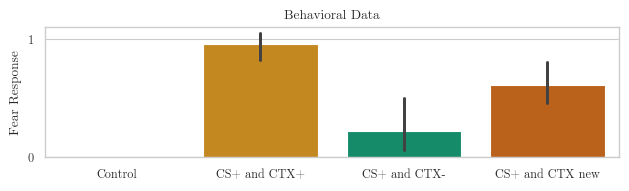

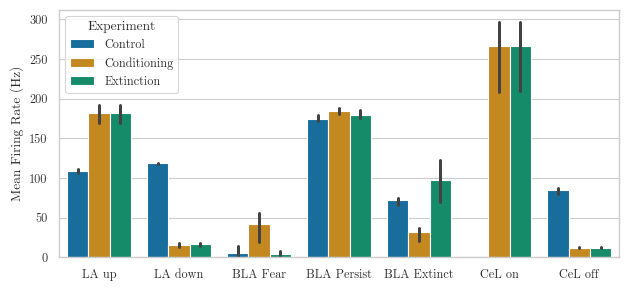

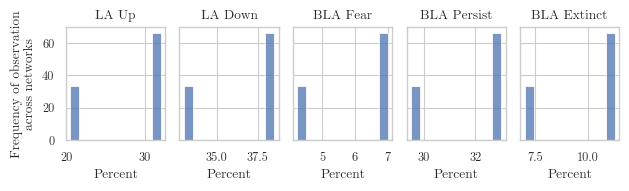

In [14]:
run_single(seeds=3, load=False, plot=True)

seed=0
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=1
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=2
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=3
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=4
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=5
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=6
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=7
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=8
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=9
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=10
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=11
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=12
control
conditioning
extinction
test CTX A
test CTX B
test CTX C
seed=13
control
conditioning
extinction
test CTX A
test CTX B

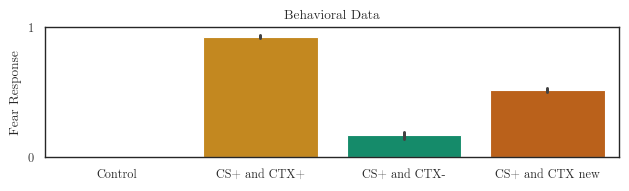

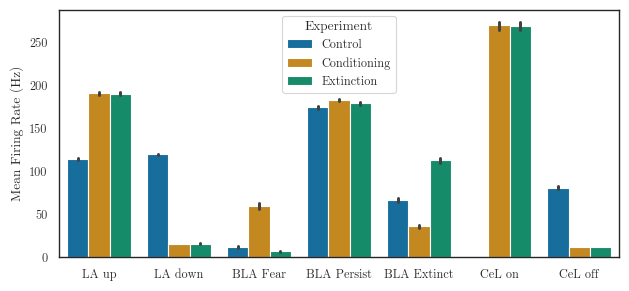

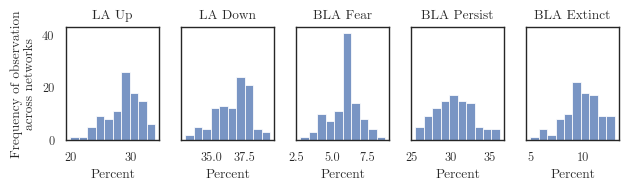

In [20]:
run_single(seeds=100, plot=False)

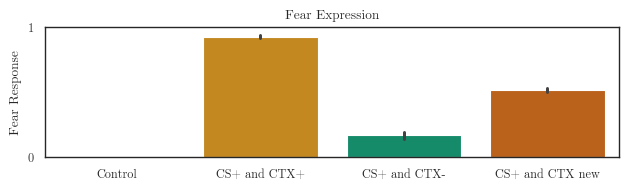

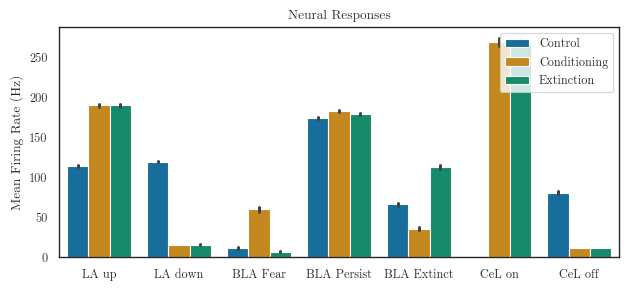

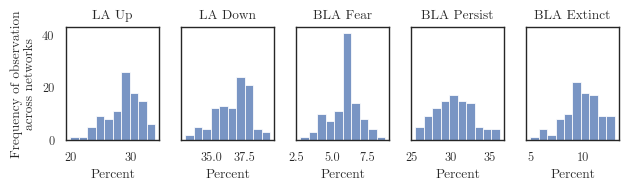

In [38]:
run_single(seeds=100, plot=False, load=True)

## Activation and Inactivation Experiments

In [7]:
def run_baseline(seed, data_baseline, blocks,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCTX=2,
        nCS=1,
    ):

    print(f"baseline")
    rng = np.random.RandomState(seed=seed)
    lr1 = rng.uniform(2e-5, 4e-5)
    lr2 = rng.uniform(8e-5, 2e-4)
    lr3 = rng.uniform(8e-6, 2e-5)
    net = build_network(seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, dt=dt, nNeurons=nNeurons,
                   nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)

    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
    with sim:
        # control
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 0
        sim.run(2)
        T1a = int(1/dt)
        T1b = int(2/dt)
        # conditioning
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 1
        for p in range(nCond):
            sim.run(2)
        T2a = int((2)/dt)
        T2b = int((2+2*nCond)/dt)
        # test (conditioning)
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 0
        sim.run(2)
        T3a = int((2+2*nCond+1)/dt)
        T3b = int((2+2*nCond+1.5)/dt)      
        # extinction 
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        for p in range(nExt):
            sim.run(2)
        T4a = int((2+2*nCond+2)/dt)
        T4b = int((2+2*nCond+2+2*nExt)/dt)
        # test (extinction)
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        sim.run(2)
        T5a = int((2+2*nCond+2+2*nExt+1)/dt)
        T5b = int((2+2*nCond+2+2*nExt+1.5)/dt)

    for block in blocks:
        data_baseline = data_baseline.append({"seed": seed, "Test" :"Spontaneous", "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]), "Block": block}, ignore_index=True)
        data_baseline = data_baseline.append({"seed": seed, "Test" :"Conditioning", "Fear Response": np.mean(sim.data[net.pCeM][T3a: T3b]), "Block": block}, ignore_index=True)
        data_baseline = data_baseline.append({"seed": seed, "Test" :"Extinction", "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]), "Block": block}, ignore_index=True)

    return data_baseline

In [26]:
def run_once(seed, target, block, stim, data_behavior, data_activity, data_response,
        nNeurons=100,
        dt=1e-3,
        nCond=5,
        nExt=10,
        dim_CS=3,
        dim_CTX=5,
        nCTX=2,
        nCS=1,
        T_current=1e1,
    ):

    print(f"seed={seed}, target={target}, block={block}, stim={stim}")
    rng = np.random.RandomState(seed=seed)
    lr1 = rng.uniform(2e-5, 4e-5)
    lr2 = rng.uniform(8e-5, 2e-4)
    lr3 = rng.uniform(8e-6, 2e-5)
    net = build_network(seed=seed, lr1=lr1, lr2=lr2, lr3=lr3, dt=dt, nNeurons=nNeurons,
                       nCond=nCond, nExt=nExt, dim_CS=dim_CS, dim_CTX=dim_CTX, nCTX=nCTX, nCS=nCS)
    with net:
        if target=="LA_pyr":
            nengo.Connection(net.applied_current, net.LA_pyr.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
        if target=="LA_inh":
            nengo.Connection(net.applied_current, net.LA_inh.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
        if target=="BLA_pyr":
            nengo.Connection(net.applied_current, net.BLA_pyr.neurons, transform=T_current*np.ones((3*nNeurons, 1)))
        if target=="BLA_inh":
            nengo.Connection(net.applied_current, net.BLA_inh.neurons, transform=T_current*np.ones((2*nNeurons, 1)))
        if target=="CeL":
            nengo.Connection(net.applied_current, net.CeL_on.neurons, transform=T_current*np.ones((nNeurons, 1)))
            nengo.Connection(net.applied_current, net.CeL_off.neurons, transform=T_current*np.ones((nNeurons, 1)))
        if target=="CeM":
            nengo.Connection(net.applied_current, net.CeM.neurons, transform=T_current*np.ones((nNeurons, 1)))
    sim = nengo.Simulator(net, dt=dt, progress_bar=False)
    with sim:
        # control
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 0
        if block=="Before\nTraining" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Before\nTraining" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        sim.run(2)
        T1a = int(1/dt)
        T1b = int(2/dt)
        # conditioning
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 1
        if block=="Conditioning\nTraining" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Conditioning\nTraining" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        for p in range(nCond):
            sim.run(2)
        T2a = int((2)/dt)
        T2b = int((2+2*nCond)/dt)
        # test (conditioning)
        net.inputs.CTX = net.inputs.CTXs[0]
        net.inputs.US = 0
        if block=="Conditioning\nTesting" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Conditioning\nTesting" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        sim.run(2)
        T3a = int((2+2*nCond+1)/dt)
        T3b = int((2+2*nCond+1.5)/dt)      
        # extinction 
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        if block=="Extinction\nTraining" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Extinction\nTraining" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        for p in range(nExt):
            sim.run(2)
        T4a = int((2+2*nCond+2)/dt)
        T4b = int((2+2*nCond+2+2*nExt)/dt)
        # test (extinction)
        net.inputs.CTX = net.inputs.CTXs[1]
        net.inputs.US = 0
        if block=="Extinction\nTesting" and stim=="Activate":
            net.inputs.applied_current = 1
        elif block=="Extinction\nTesting" and stim=="Inactivate":
            net.inputs.applied_current = -1
        else:
            net.inputs.applied_current = 0
        sim.run(2)
        T5a = int((2+2*nCond+2+2*nExt+1)/dt)
        T5b = int((2+2*nCond+2+2*nExt+1.5)/dt)


    data_behavior = data_behavior.append({"seed": seed, "Test" :"Spontaneous", "Fear Response": np.mean(sim.data[net.pCeM][T1a: T1b]), "Stimulus": stim, "Block": block},ignore_index=True)
    data_behavior = data_behavior.append({"seed": seed, "Test" :"Conditioning", "Fear Response": np.mean(sim.data[net.pCeM][T3a: T3b]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_behavior = data_behavior.append({"seed": seed, "Test" :"Extinction", "Fear Response": np.mean(sim.data[net.pCeM][T5a: T5b]), "Stimulus": stim, "Block": block}, ignore_index=True)

    aControl_LA_pyr = sim.data[net.pLA_pyr_spikes][T1a: T1b]
    aConditioning_LA_pyr = sim.data[net.pLA_pyr_spikes][T3a: T3b]
    aExtinction_LA_pyr = sim.data[net.pLA_pyr_spikes][T5a: T5b]
    aControl_CeL_on = sim.data[net.pCeL_on_spikes][T1a: T1b]
    aConditioning_CeL_on = sim.data[net.pCeL_on_spikes][T3a: T3b]
    aExtinction_CeL_on = sim.data[net.pCeL_on_spikes][T5a: T5b]
    aControl_CeL_off = sim.data[net.pCeL_off_spikes][T1a: T1b]
    aConditioning_CeL_off = sim.data[net.pCeL_off_spikes][T3a: T3b]
    aExtinction_CeL_off = sim.data[net.pCeL_off_spikes][T5a: T5b]
    aControl_BLA = sim.data[net.pBLA_pyr_spikes][T1a: T1b]
    aConditioning_BLA = sim.data[net.pBLA_pyr_spikes][T3a: T3b]
    aExtinction_BLA = sim.data[net.pBLA_pyr_spikes][T5a: T5b]    

    LA_pyr_up = np.where(np.mean(aConditioning_LA_pyr, axis=0) > 1.5*np.mean(aControl_LA_pyr, axis=0))[0]
    LA_pyr_down = np.where(np.mean(aConditioning_LA_pyr, axis=0) < 0.5*np.mean(aControl_LA_pyr, axis=0))[0]
    fear_neurons_p1 = np.where(np.mean(aConditioning_BLA, axis=0) > 1.5*np.mean(aControl_BLA, axis=0))[0]
    fear_neurons_p2 = np.where(np.mean(aExtinction_BLA, axis=0) < 0.5*np.mean(aConditioning_BLA, axis=0))[0]
    fear_neurons = np.intersect1d(fear_neurons_p1, fear_neurons_p2)
    extinction_neurons = np.where(np.mean(aExtinction_BLA, axis=0) > 1.5*np.mean(aConditioning_BLA, axis=0))[0]
    persistent_neurons = np.where(np.abs(np.mean(aConditioning_BLA-aExtinction_BLA,axis=0))<0.5*np.mean(aConditioning_BLA, axis=0))[0]

    data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_up]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_up]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA up", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_up]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aControl_LA_pyr[:,LA_pyr_down]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aConditioning_LA_pyr[:,LA_pyr_down]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "LA down", "Activity": np.mean(aExtinction_LA_pyr[:,LA_pyr_down]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aControl_BLA[:,fear_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aConditioning_BLA[:,fear_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Fear", "Activity": np.mean(aExtinction_BLA[:,fear_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aControl_BLA[:,persistent_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aConditioning_BLA[:,persistent_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Persistent", "Activity": np.mean(aExtinction_BLA[:,persistent_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aControl_BLA[:,extinction_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aConditioning_BLA[:,extinction_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "BLA Extinction", "Activity": np.mean(aExtinction_BLA[:,extinction_neurons]), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aControl_CeL_on), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aConditioning_CeL_on), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL on", "Activity": np.mean(aExtinction_CeL_on), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aControl_CeL_off), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aConditioning_CeL_off), "Stimulus": stim, "Block": block}, ignore_index=True)
    data_activity = data_activity.append({"seed": seed, "Type": "CeL off", "Activity": np.mean(aExtinction_CeL_off), "Stimulus": stim, "Block": block}, ignore_index=True)

    percent_up = len(LA_pyr_up)/(2*nNeurons)*100
    percent_down = len(LA_pyr_down)/(2*nNeurons)*100
    percent_fear = len(fear_neurons)/(4*nNeurons)*100
    percent_extinction = len(extinction_neurons)/(4*nNeurons)*100
    percent_persistent = len(persistent_neurons)/(4*nNeurons)*100
    data_response = data_response.append({"seed": seed, "Type": "LA up", "Percent": percent_up, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "LA down", "Percent": percent_down, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "BLA Fear", "Percent": percent_fear, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "BLA Extinction", "Percent": percent_extinction, "Stimulus": stim, "Block": block}, ignore_index=True)
    data_response = data_response.append({"seed": seed, "Type": "BLA Persistent", "Percent": percent_persistent, "Stimulus": stim, "Block": block}, ignore_index=True)

    return data_behavior, data_activity, data_response

In [9]:
def plot_activation_inactivation(data_baseline, data_behavior, data_activity, data_response, stims, blocks, target):
    sns.set(context='paper', style='whitegrid', font='CMU Serif')
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)), sharex=True)
    bar1 = sns.barplot(data=data_behavior.query("Stimulus=='Inactivate'"), x='Block', y='Fear Response', hue="Test", ax=axes[0])
    bar2 = sns.barplot(data=data_baseline, x='Block', y='Fear Response', hue="Test", ax=axes[1])
    bar3 = sns.barplot(data=data_behavior.query("Stimulus=='Activate'"),x='Block', y='Fear Response', hue="Test", ax=axes[2])
    axes[0].set(title="Inhibition", yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)), ylim=((0, 1.0)), xlabel=None)
    axes[1].set(title="Baseline", yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)), ylim=((0, 1.0)), xlabel=None)
    axes[2].set(title="Activation", yticks=((0, 0.2, 0.4, 0.6, 0.8, 1.0)), ylim=((0, 1.0)), xlabel="External Stimulus Applied During Stage X")
    axes[0].get_legend().remove()
    axes[2].get_legend().remove()
#     for bar in bar1.patches: bar.set_hatch("...")
#     for bar in bar2.patches: bar.set_hatch("xxx")
#     for bar in bar3.patches: bar.set_hatch("xxx")
    plt.tight_layout()
    fig.savefig(f"activation_inactivation_{target}.png")

In [10]:
def run_activation_inactivation(
    seeds=2,
    stims=["Activate", "Inactivate"],
    blocks=["Before Training", "Conditioning Training", "Conditioning Testing", "Extinction Training", "Extinction Testing"],
    target="LA_pyr",
    load=False,
    redo_baseline=False
    ):
    
    if redo_baseline:
        data_baseline = pd.DataFrame(columns=["seed", "Fear Response", "Stimulus", "Block", "Test"])
        for seed in range(seeds):
            data_baseline = run_baseline(seed, data_baseline,
                blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"])
        data_baseline.to_pickle(f"activation_inactivation_baseline.pkl")
    else:
        data_baseline = pd.read_pickle(f"activation_inactivation_baseline.pkl")

    if load:
        data_behavior = pd.read_pickle(f"activation_inactivation_behavior_{target}.pkl")
        data_activity = pd.read_pickle(f"activation_inactivation_activity_{target}.pkl")
        data_response = pd.read_pickle(f"activation_inactivation_response_{target}.pkl")        
    else:
        data_behavior = pd.DataFrame(columns=["seed", "Fear Response", "Stimulus", "Block", "Test"])
        data_activity = pd.DataFrame(columns=["seed", "Activity", "Stimulus", "Block", "Type"])
        data_response = pd.DataFrame(columns=["seed", "Percent", "Stimulus", "Block", "Type"])
        for seed in range(seeds):
            for stim in stims:
                for block in blocks:
                    data_behavior, data_activity, data_response = run_once(
                        seed, target, block, stim, data_behavior, data_activity, data_response)
        data_behavior.to_pickle(f"activation_inactivation_behavior_{target}.pkl")
        data_activity.to_pickle(f"activation_inactivation_activity_{target}.pkl")
        data_response.to_pickle(f"activation_inactivation_response_{target}.pkl")

    plot_activation_inactivation(data_baseline, data_behavior, data_activity, data_response, stims, blocks, target)

baseline
seed=0, target=LA_pyr, block=Before
Training, stim=Activate


/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


seed=0, target=LA_pyr, block=Conditioning
Training, stim=Activate
seed=0, target=LA_pyr, block=Conditioning
Testing, stim=Activate
seed=0, target=LA_pyr, block=Extinction
Training, stim=Activate
seed=0, target=LA_pyr, block=Extinction
Testing, stim=Activate
seed=0, target=LA_pyr, block=Before
Training, stim=Inactivate
seed=0, target=LA_pyr, block=Conditioning
Training, stim=Inactivate
seed=0, target=LA_pyr, block=Conditioning
Testing, stim=Inactivate
seed=0, target=LA_pyr, block=Extinction
Training, stim=Inactivate
seed=0, target=LA_pyr, block=Extinction
Testing, stim=Inactivate


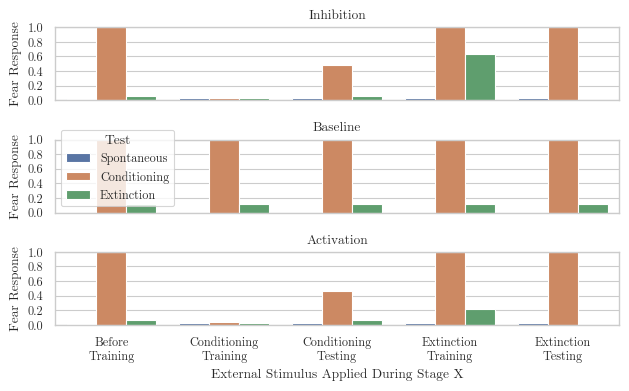

In [11]:
run_activation_inactivation(
    seeds=1,
    stims=["Activate", "Inactivate"],
    blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"],
    target="LA_pyr",
    load=False,
    redo_baseline=True)

seed=0, target=LA_pyr, block=Before
Training, stim=Activate


/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


seed=0, target=LA_pyr, block=Conditioning
Training, stim=Activate
seed=0, target=LA_pyr, block=Conditioning
Testing, stim=Activate
seed=0, target=LA_pyr, block=Extinction
Training, stim=Activate
seed=0, target=LA_pyr, block=Extinction
Testing, stim=Activate
seed=0, target=LA_pyr, block=Before
Training, stim=Inactivate
seed=0, target=LA_pyr, block=Conditioning
Training, stim=Inactivate
seed=0, target=LA_pyr, block=Conditioning
Testing, stim=Inactivate
seed=0, target=LA_pyr, block=Extinction
Training, stim=Inactivate
seed=0, target=LA_pyr, block=Extinction
Testing, stim=Inactivate
seed=1, target=LA_pyr, block=Before
Training, stim=Activate
seed=1, target=LA_pyr, block=Conditioning
Training, stim=Activate
seed=1, target=LA_pyr, block=Conditioning
Testing, stim=Activate
seed=1, target=LA_pyr, block=Extinction
Training, stim=Activate
seed=1, target=LA_pyr, block=Extinction
Testing, stim=Activate
seed=1, target=LA_pyr, block=Before
Training, stim=Inactivate
seed=1, target=LA_pyr, block=Condi

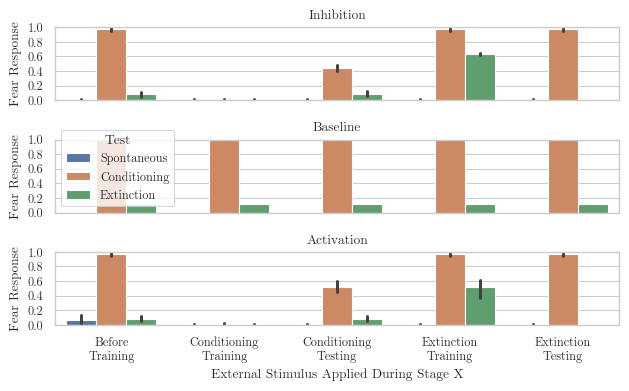

In [21]:
run_activation_inactivation(
    seeds=5,
    stims=["Activate", "Inactivate"],
    blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"],
    target="LA_pyr",
    load=False,
    redo_baseline=False)

seed=0, target=LA_inh, block=Before
Training, stim=Activate
seed=0, target=LA_inh, block=Conditioning
Training, stim=Activate


/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


seed=0, target=LA_inh, block=Conditioning
Testing, stim=Activate
seed=0, target=LA_inh, block=Extinction
Training, stim=Activate
seed=0, target=LA_inh, block=Extinction
Testing, stim=Activate
seed=0, target=LA_inh, block=Before
Training, stim=Inactivate
seed=0, target=LA_inh, block=Conditioning
Training, stim=Inactivate
seed=0, target=LA_inh, block=Conditioning
Testing, stim=Inactivate
seed=0, target=LA_inh, block=Extinction
Training, stim=Inactivate
seed=0, target=LA_inh, block=Extinction
Testing, stim=Inactivate
seed=1, target=LA_inh, block=Before
Training, stim=Activate
seed=1, target=LA_inh, block=Conditioning
Training, stim=Activate
seed=1, target=LA_inh, block=Conditioning
Testing, stim=Activate
seed=1, target=LA_inh, block=Extinction
Training, stim=Activate
seed=1, target=LA_inh, block=Extinction
Testing, stim=Activate
seed=1, target=LA_inh, block=Before
Training, stim=Inactivate
seed=1, target=LA_inh, block=Conditioning
Training, stim=Inactivate
seed=1, target=LA_inh, block=Con

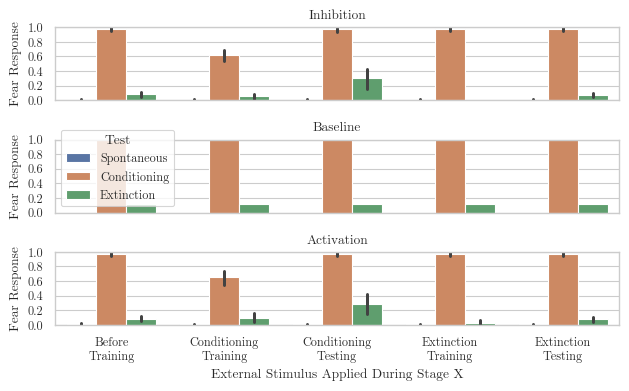

In [22]:
run_activation_inactivation(
    seeds=5,
    stims=["Activate", "Inactivate"],
    blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"],
    target="LA_inh",
    load=False,
    redo_baseline=False)

seed=0, target=BLA_pyr, block=Before
Training, stim=Activate


/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pduggins/amygdala/.venv/lib64/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


seed=0, target=BLA_pyr, block=Conditioning
Training, stim=Activate
seed=0, target=BLA_pyr, block=Conditioning
Testing, stim=Activate
seed=0, target=BLA_pyr, block=Extinction
Training, stim=Activate
seed=0, target=BLA_pyr, block=Extinction
Testing, stim=Activate
seed=0, target=BLA_pyr, block=Before
Training, stim=Inactivate
seed=0, target=BLA_pyr, block=Conditioning
Training, stim=Inactivate
seed=0, target=BLA_pyr, block=Conditioning
Testing, stim=Inactivate
seed=0, target=BLA_pyr, block=Extinction
Training, stim=Inactivate
seed=0, target=BLA_pyr, block=Extinction
Testing, stim=Inactivate
seed=1, target=BLA_pyr, block=Before
Training, stim=Activate
seed=1, target=BLA_pyr, block=Conditioning
Training, stim=Activate
seed=1, target=BLA_pyr, block=Conditioning
Testing, stim=Activate
seed=1, target=BLA_pyr, block=Extinction
Training, stim=Activate
seed=1, target=BLA_pyr, block=Extinction
Testing, stim=Activate
seed=1, target=BLA_pyr, block=Before
Training, stim=Inactivate
seed=1, target=BLA_

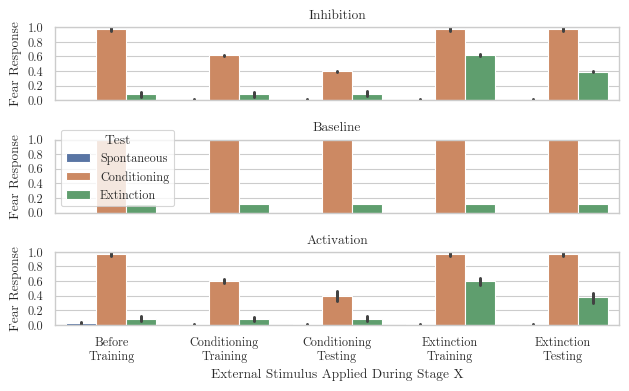

In [23]:
run_activation_inactivation(
    seeds=5,
    stims=["Activate", "Inactivate"],
    blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"],
    target="BLA_pyr",
    load=False,
    redo_baseline=False)

seed=0, target=BLA_inh, block=Before
Training, stim=Activate
seed=0, target=BLA_inh, block=Conditioning
Training, stim=Activate
seed=0, target=BLA_inh, block=Conditioning
Testing, stim=Activate
seed=0, target=BLA_inh, block=Extinction
Training, stim=Activate
seed=0, target=BLA_inh, block=Extinction
Testing, stim=Activate
seed=0, target=BLA_inh, block=Before
Training, stim=Inactivate
seed=0, target=BLA_inh, block=Conditioning
Training, stim=Inactivate
seed=0, target=BLA_inh, block=Conditioning
Testing, stim=Inactivate
seed=0, target=BLA_inh, block=Extinction
Training, stim=Inactivate
seed=0, target=BLA_inh, block=Extinction
Testing, stim=Inactivate
seed=1, target=BLA_inh, block=Before
Training, stim=Activate
seed=1, target=BLA_inh, block=Conditioning
Training, stim=Activate
seed=1, target=BLA_inh, block=Conditioning
Testing, stim=Activate
seed=1, target=BLA_inh, block=Extinction
Training, stim=Activate
seed=1, target=BLA_inh, block=Extinction
Testing, stim=Activate
seed=1, target=BLA_in

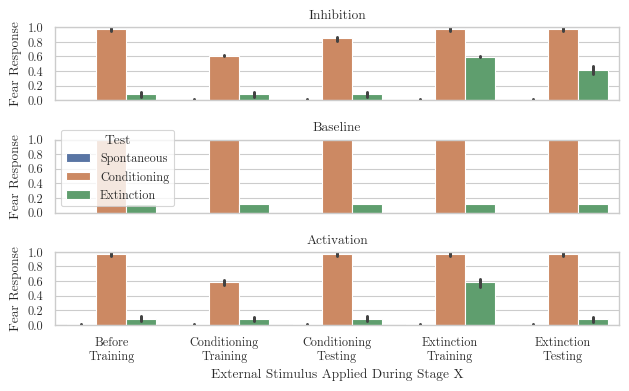

In [24]:
run_activation_inactivation(
    seeds=5,
    stims=["Activate", "Inactivate"],
    blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"],
    target="BLA_inh",
    load=False,
    redo_baseline=False)

In [25]:
run_activation_inactivation(
    seeds=5,
    stims=["Activate", "Inactivate"],
    blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"],
    target="CeL",
    load=False,
    redo_baseline=False)

seed=0, target=CeL, block=Before
Training, stim=Activate
seed=0, target=CeL, block=Conditioning
Training, stim=Activate
seed=0, target=CeL, block=Conditioning
Testing, stim=Activate
seed=0, target=CeL, block=Extinction
Training, stim=Activate
seed=0, target=CeL, block=Extinction
Testing, stim=Activate
seed=0, target=CeL, block=Before
Training, stim=Inactivate
seed=0, target=CeL, block=Conditioning
Training, stim=Inactivate
seed=0, target=CeL, block=Conditioning
Testing, stim=Inactivate
seed=0, target=CeL, block=Extinction
Training, stim=Inactivate
seed=0, target=CeL, block=Extinction
Testing, stim=Inactivate
seed=1, target=CeL, block=Before
Training, stim=Activate


KeyboardInterrupt: 

In [ ]:
run_activation_inactivation(
    seeds=5,
    stims=["Activate", "Inactivate"],
    blocks=["Before\nTraining", "Conditioning\nTraining", "Conditioning\nTesting", "Extinction\nTraining", "Extinction\nTesting"],
    target="CeM",
    load=False,
    redo_baseline=False)